In [1]:
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
import numpy as np
import cv2

In [2]:
images_list = list(Path('/kaggle/input/image-matching-challenge-2024/test/church/images/').glob('*.png'))[8:12]
images_list

[PosixPath('/kaggle/input/image-matching-challenge-2024/test/church/images/00063.png'),
 PosixPath('/kaggle/input/image-matching-challenge-2024/test/church/images/00046.png'),
 PosixPath('/kaggle/input/image-matching-challenge-2024/test/church/images/00111.png'),
 PosixPath('/kaggle/input/image-matching-challenge-2024/test/church/images/00066.png')]

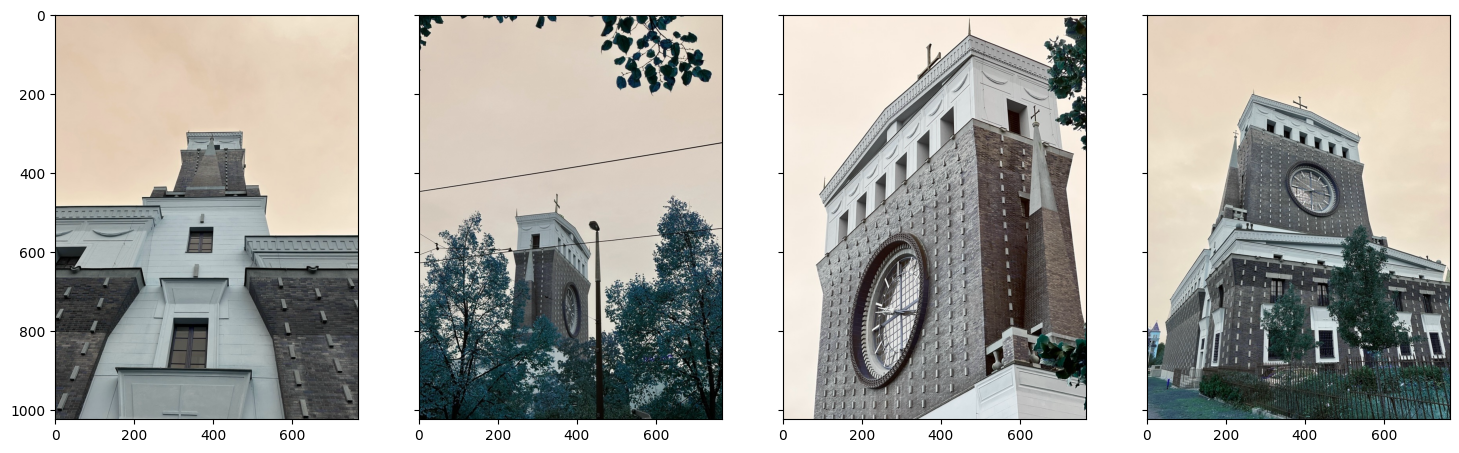

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(18, 12), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    image = cv2.imread(str(images_list[i]))
    fig_x.imshow(image)

In [4]:
detector = cv2.AKAZE_create()
bf = cv2.BFMatcher()

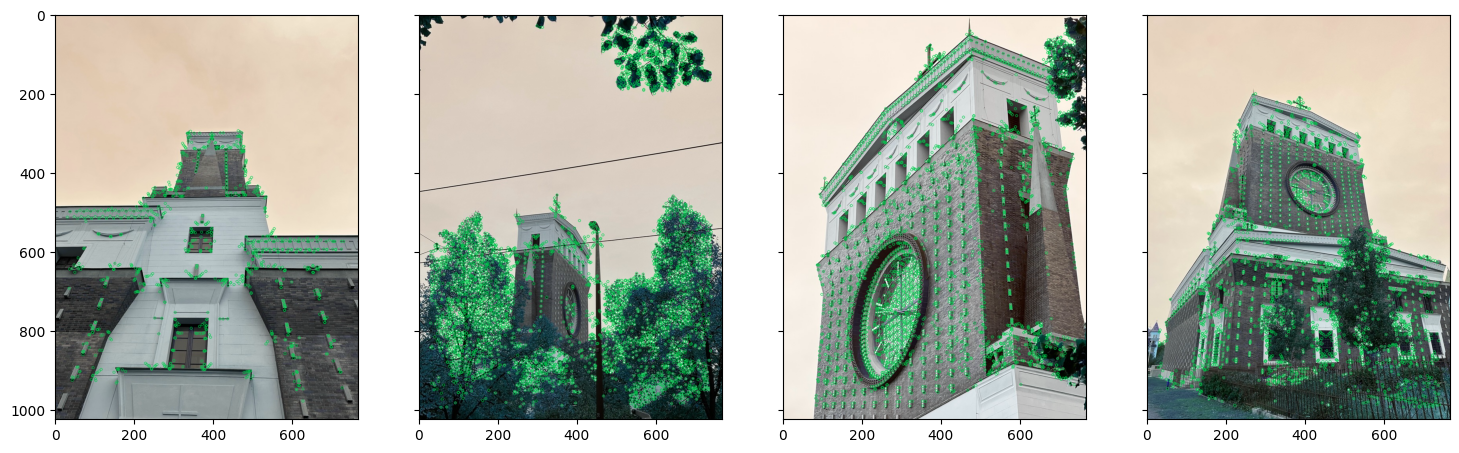

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(18, 12), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    image = cv2.imread(str(images_list[i]))
    (kps, descs) = detector.detectAndCompute(image, None)
    cv2.drawKeypoints(image, kps, image, (0, 205, 78))
    fig_x.imshow(image)

In [6]:
matches = []
for current_image_index in range(len(images_list)):
    for image_index in range(len(images_list)):
        if image_index == current_image_index: 
               continue
        result = list(sorted([current_image_index, image_index]))
        matches.append(tuple(result))


matches = sorted(list(set(matches))) 
matches       

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [7]:
def get_point(path1, path2):
    img1 = cv2.resize(cv2.imread(str(path1),cv2.IMREAD_GRAYSCALE), (0,0), fx=0.5, fy=0.5)
    img2 = cv2.resize(cv2.imread(str(path2),cv2.IMREAD_GRAYSCALE), (0,0), fx=0.5, fy=0.5)
    kp1, des1 = detector.detectAndCompute(img1, None)
    kp2, des2 = detector.detectAndCompute(img2 ,None)
    return img1, img2, kp1, des1, kp2, des2

In [8]:
def get_image_with_point_akaze(img1, img2, kp1, des1, kp2, des2):
    matches = bf.knnMatch(des1,des2,k=2)
    distances = []
    for m,n in matches:
        if m.distance < 0.9*n.distance:
            distances.append([m])
    image = cv2.drawMatchesKnn(img1,kp1,img2,kp2,distances,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchColor=(0,205,58))
    return image

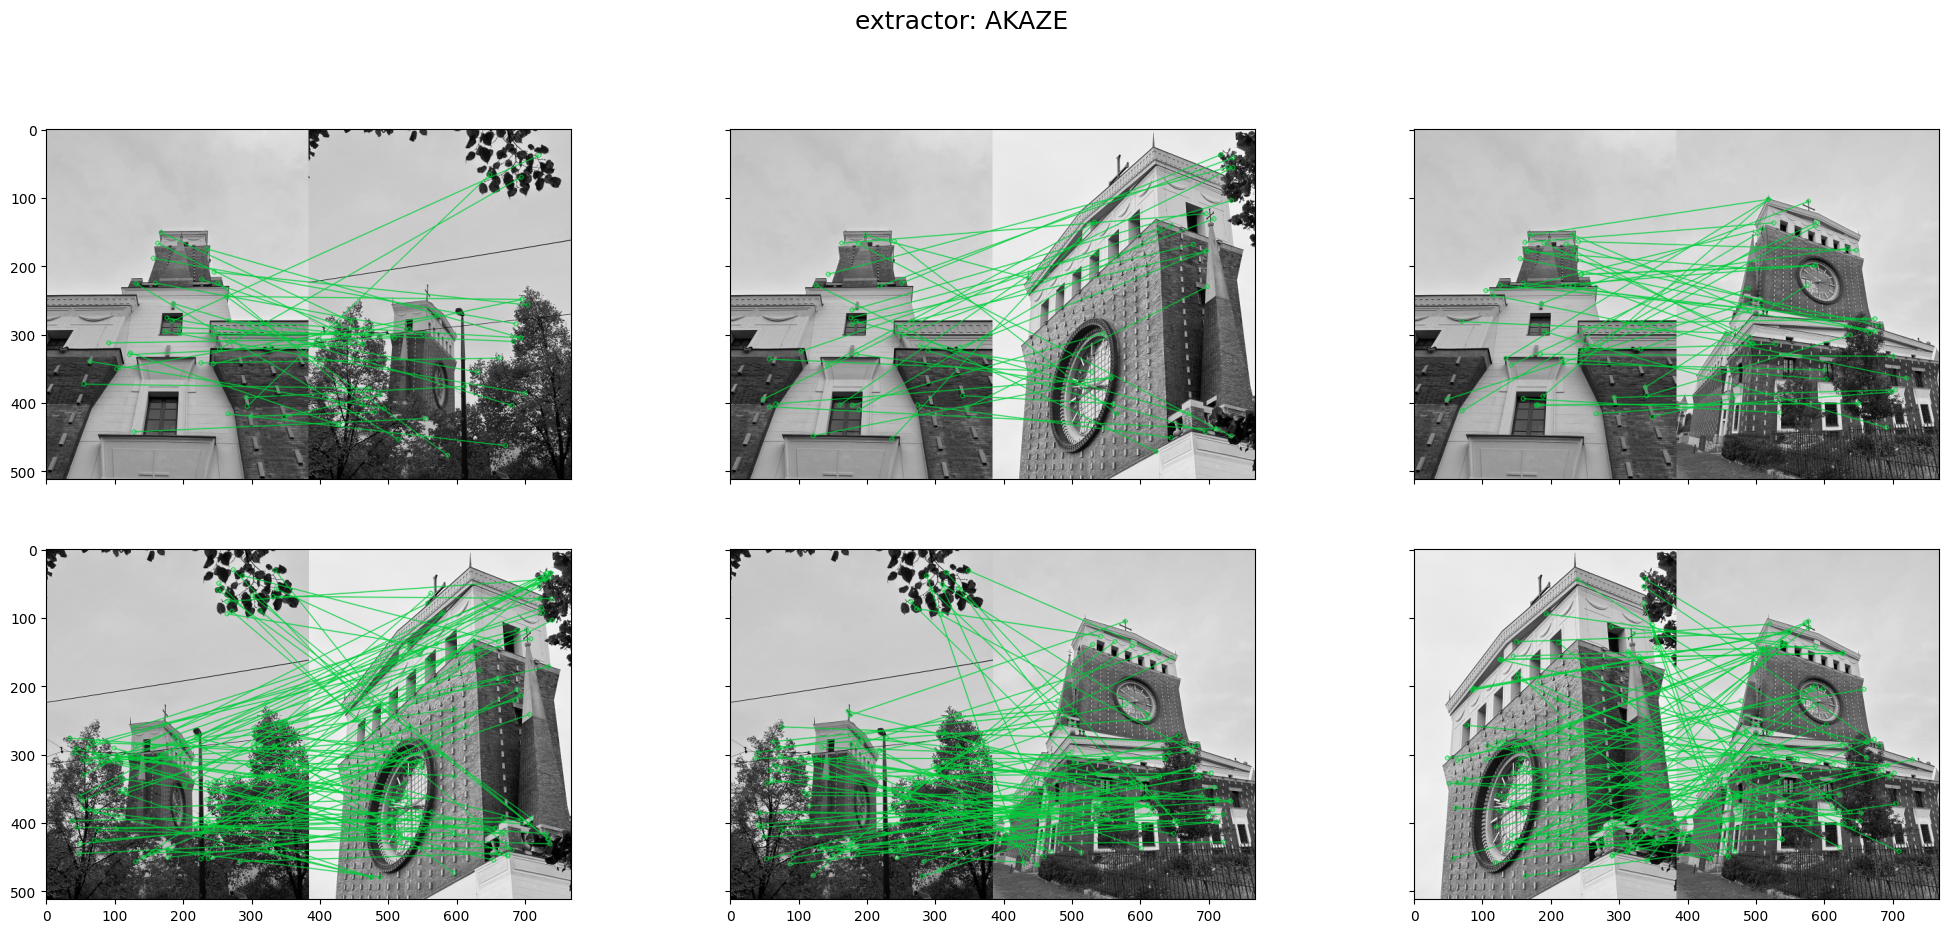

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10), sharey=True, sharex=True)
plt.suptitle(f'extractor: AKAZE', y=1, fontsize=18)
for i, fig_x in enumerate(ax.flatten()):
    img1, img2, kp1, des1, kp2, des2 = get_point(images_list[matches[i][0]], images_list[matches[i][1]])
    image = get_image_with_point_akaze(img1, img2, kp1, des1, kp2, des2)
    fig_x.imshow(image)
    

In [10]:
def get_image_with_point_akaze_homo(img1, img2, kp1, des1, kp2, des2):
    min_match_count = 10
    distances = []
    matches = bf.knnMatch(des1,des2,k=2)
    for m,n in matches:
        if m.distance < 0.95*n.distance:
            distances.append(m)
            
    if len(distances) > min_match_count:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in distances]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in distances]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h, w  = img1.shape
        pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print('Key Point : {}/{}'.format(len(distances), min_match_count))
        matchesMask = None

    draw_params = dict(matchColor = (0,205,58), 
                       singlePointColor = None,
                       matchesMask = matchesMask,
                       flags = 2)
    image = cv2.drawMatches(img1,kp1,img2,kp2,distances,None,**draw_params)        
    return image

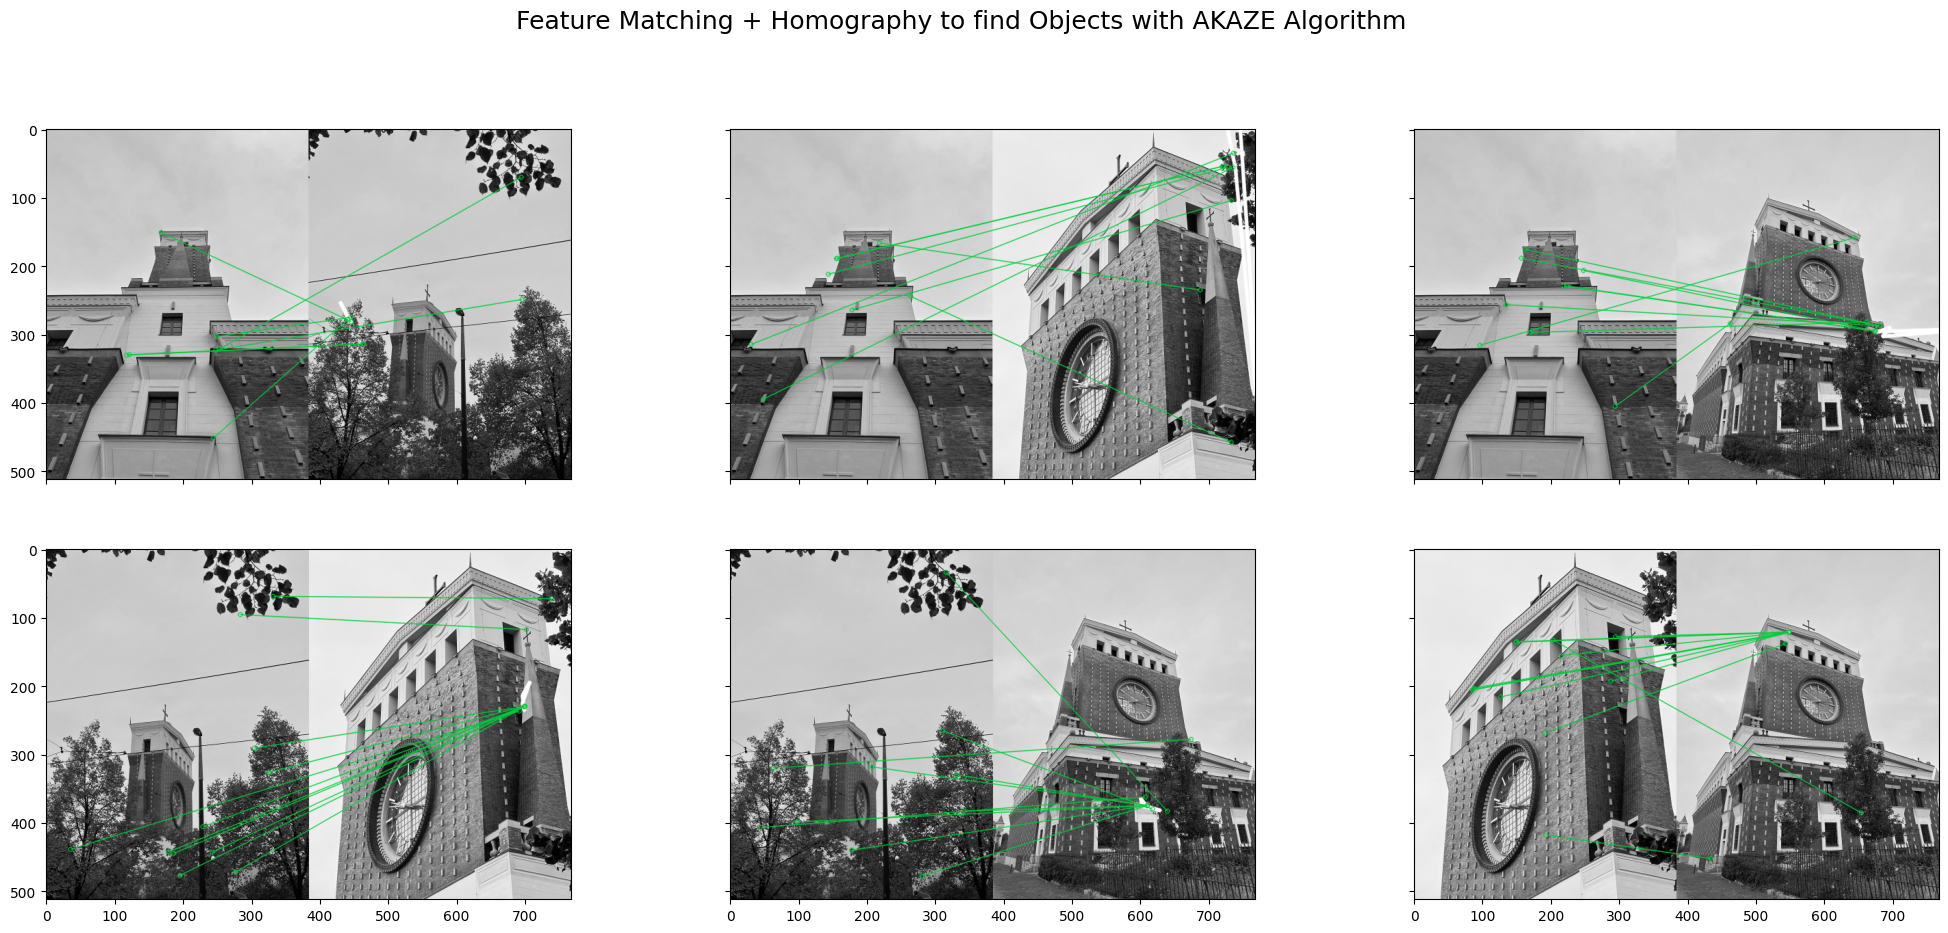

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10), sharey=True, sharex=True)
plt.suptitle(f'Feature Matching + Homography to find Objects with AKAZE Algorithm', y=1, fontsize=18)
for i, fig_x in enumerate(ax.flatten()):
    img1, img2, kp1, des1, kp2, des2 = get_point(images_list[matches[i][0]], images_list[matches[i][1]])
    image = get_image_with_point_akaze_homo(img1, img2, kp1, des1, kp2, des2)
    fig_x.imshow(image)